In [3]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

In [ ]:
#Reading the csv file
basket_data=pd.read_csv('/content/Basket_dataset.csv')

In [5]:
#Look at how the data looks like and what variables it consists of.
basket_data.head()

,Member_number,Date,itemDescription
0,1808,21/07/2015,tropical fruit
1,2552,05/01/2015,whole milk
2,2300,19/09/2015,pip fruit
3,1187,12/12/2015,other vegetables
4,3037,01/02/2015,whole milk


In [6]:
#look at the type of data in the dataset and identify the variables
basket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [7]:
# Change the Member_number variable to object its a customer identifier
basket_data['Member_number'] = basket_data['Member_number'].astype(str)

In [8]:
#Column naming convention for easy understanding.
basket_data.columns = ['Member_ID', 'Date', 'Product_Name']
basket_data.head()

,Member_ID,Date,Product_Name
0,1808,21/07/2015,tropical fruit
1,2552,05/01/2015,whole milk
2,2300,19/09/2015,pip fruit
3,1187,12/12/2015,other vegetables
4,3037,01/02/2015,whole milk


In [9]:
#Statistical exploration of te data set
basket_data.describe()

,Member_ID,Date,Product_Name
count,38765,38765,38765
unique,3898,728,167
top,3180,21/01/2015,whole milk
freq,36,96,2502


In [10]:
#Interogate the dataset to find any missing values from the set.
basket_data.isna().sum()

Member_ID       0
Date            0
Product_Name    0
dtype: int64

In [11]:
# Converte the Date column into correct datatype (datetime)
basket_data.Date = pd.to_datetime(basket_data.Date)
basket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Member_ID     38765 non-null  object        
 1   Date          38765 non-null  datetime64[ns]
 2   Product_Name  38765 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 908.7+ KB


<ipython-input-11-f102f6d0c9fb>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  basket_data.Date = pd.to_datetime(basket_data.Date)


In [12]:
#The basket tabble to be used in RFM
RFM_df = basket_data
RFM_df.head()

,Member_ID,Date,Product_Name
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


In [13]:
#RFM Analysis
!pip install apyori

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5955 sha256=9246fa507221b6d211506c03fd2f25f2928e2e25f0e892b3afb41486e760d73f
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


In [14]:
#Set up SQL and Read the data
import pandas as pd
import sqlite3
from apyori import apriori

In [15]:
#Connect to an SQL database
conn = sqlite3.connect("Marketdb")
cur = conn.cursor()

#Load the basket data into the RFM_df database
RFM_df.to_sql("rfmdata", conn)

#Check to ensure that data inserted is in the RFM_df DB
RFM_df = pd.read_sql('SELECT * FROM rfmdata', conn)
RFM_df

,index,Member_ID,Date,Product_Name
0,0,1808,2015-07-21 00:00:00,tropical fruit
1,1,2552,2015-01-05 00:00:00,whole milk
2,2,2300,2015-09-19 00:00:00,pip fruit
3,3,1187,2015-12-12 00:00:00,other vegetables
4,4,3037,2015-02-01 00:00:00,whole milk
...,...,...,...,...
38760,38760,4471,2014-10-08 00:00:00,sliced cheese
38761,38761,2022,2014-02-23 00:00:00,candy
38762,38762,1097,2014-04-16 00:00:00,cake bar
38763,38763,1510,2014-12-03 00:00:00,fruit/vegetable juice


In [16]:
#Calculate RFM metric values for each customer using SQL query

RFM_cleandata3= pd.read_sql(''' SELECT Member_ID,
                   MAX(Date) AS Last_purchase_date,
                   julianday('2015-12-31') - julianday(MAX(Date)) AS Recency,
                   COUNT(DISTINCT(Date)) AS Frequency,
                   COUNT(Product_Name) AS Monetary

            FROM rfmdata
            GROUP BY Member_ID ''', conn)

# Write computed RFM values into the database
RFM_cleandata3.to_sql("RFM_cleandata3", conn)


3898

In [17]:
#Look at the RFM metrics table
RFM_cleandata3.head()

,Member_ID,Last_purchase_date,Recency,Frequency,Monetary
0,1000,2015-11-25 00:00:00,36.0,5,13
1,1001,2015-05-02 00:00:00,243.0,5,12
2,1002,2015-08-30 00:00:00,123.0,4,8
3,1003,2015-02-10 00:00:00,324.0,4,8
4,1004,2015-12-02 00:00:00,29.0,8,21


In [18]:
#Read a clean table
#Create a plain table to use for  RFM examination
RFM_metrics=RFM_cleandata3[["Member_ID","Recency","Frequency","Monetary"]]
RFM_metrics.head()

,Member_ID,Recency,Frequency,Monetary
0,1000,36.0,5,13
1,1001,243.0,5,12
2,1002,123.0,4,8
3,1003,324.0,4,8
4,1004,29.0,8,21


In [19]:
#Check the statistical information of the RFM values
RFM_metrics.describe()

,Recency,Frequency,Monetary
count,3898.000000,3898.000000,3898.000000
mean,188.701385,3.838635,9.944844
std,159.912688,1.883678,5.310796
min,1.000000,1.000000,2.000000
25%,58.000000,2.000000,6.000000
50%,142.000000,4.000000,9.000000
75%,281.000000,5.000000,13.000000
max,728.000000,11.000000,36.000000


In [20]:
#Take the required feature column to be fitted
RFM_fit=RFM_metrics[["Recency","Frequency", "Monetary"]]
RFM_fit

,Recency,Frequency,Monetary
0,36.0,5,13
1,243.0,5,12
2,123.0,4,8
3,324.0,4,8
4,29.0,8,21
...,...,...,...
3893,37.0,3,10
3894,4.0,2,6
3895,78.0,1,2
3896,5.0,6,16


Text(0.5, 1.0, 'Histogram of Recency')

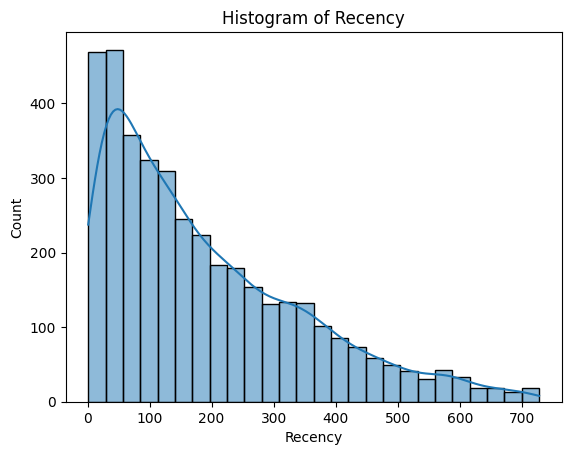

In [21]:
#Examine the distribution of Recency

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=RFM_fit, x='Recency', kde=True)
ax.set_title('Histogram of Recency')

Text(0.5, 1.0, 'Histogram of Frequency')

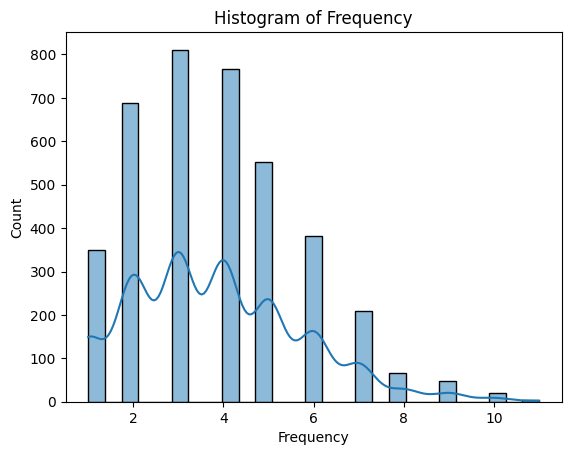

In [22]:
#Examine the distribution of Frequency

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=RFM_fit, x='Frequency', kde=True)
ax.set_title('Histogram of Frequency')

Text(0.5, 1.0, 'Histogram of Monetary')

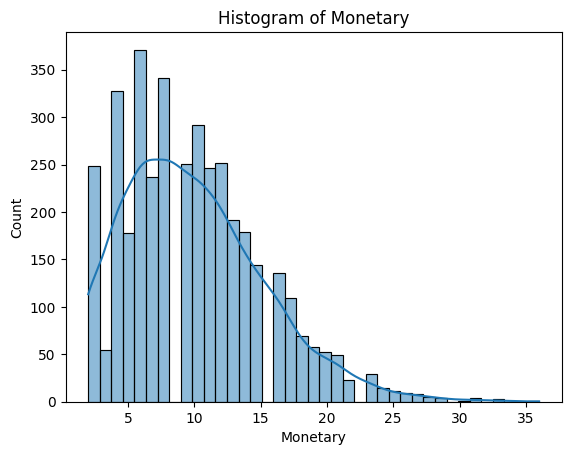

In [23]:
#Examine the distribution of Monetary

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=RFM_fit, x='Monetary', kde=True)
ax.set_title('Histogram of Monetary')

In [24]:
RFM_fit

,Recency,Frequency,Monetary
0,36.0,5,13
1,243.0,5,12
2,123.0,4,8
3,324.0,4,8
4,29.0,8,21
...,...,...,...
3893,37.0,3,10
3894,4.0,2,6
3895,78.0,1,2
3896,5.0,6,16


In [25]:
#Select a suitable minPts using the rule of thumb with (2*3) features (RFM)
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(RFM_fit)
distances, indices = neighbors_fit.kneighbors(RFM_fit)

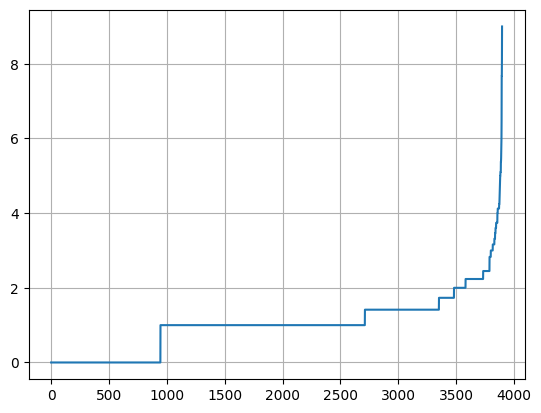

In [26]:
#Plot the k-distance plot to determin the eps value at the elbow
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid(True)

In [27]:
#calculate the eps using knee
!pip install kneed

In [28]:
#import libraries for DBSCAN
from kneed import KneeLocator
from sklearn.cluster import DBSCAN

7.681145747868608


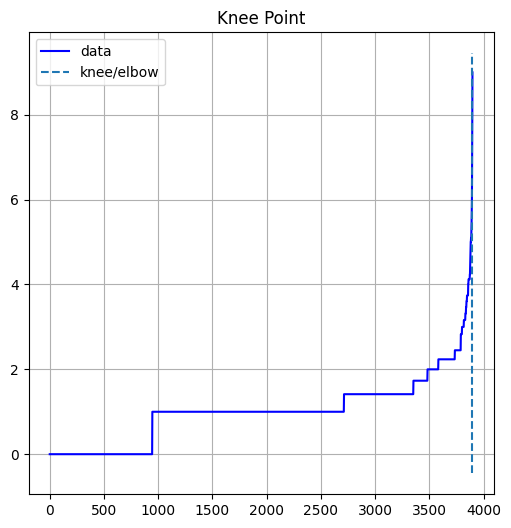

In [29]:
kneedle = KneeLocator(x = range(1, len(distances)+1), y = distances, S = 1.0,
                      curve = "concave", direction = "increasing", online=True)

kneedle.plot_knee()
plt.grid(True)

# get the estimate of knee point
print(kneedle.knee_y)

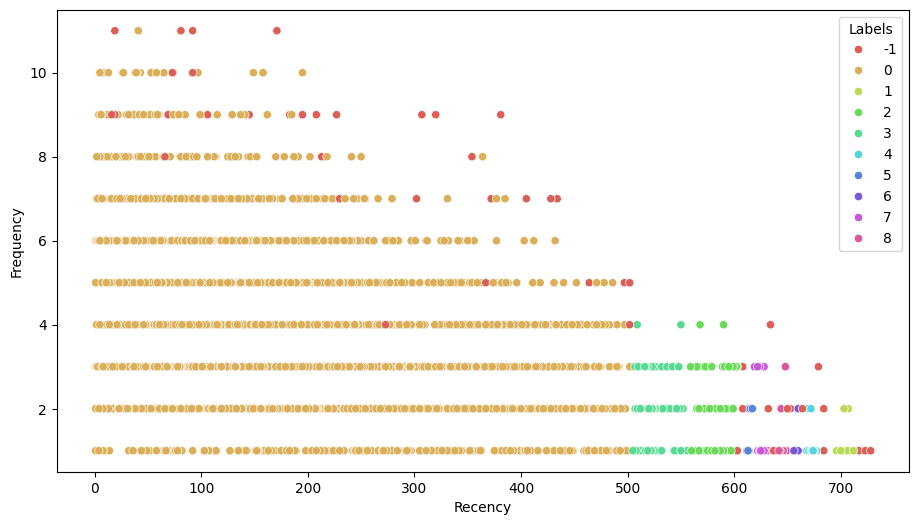

In [38]:
#Fit DBSCAN and plot Recency vs Frequency
db = DBSCAN(eps=5, min_samples=6).fit(RFM_fit)

RFM_fit['Labels'] = db.labels_
plt.figure(figsize=(11, 6))
sns.scatterplot(x="Recency", y="Frequency", data = RFM_fit, hue=RFM_fit.Labels,
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
#plt.title('DBSCAN with epsilon 5, min samples 6')
plt.show()


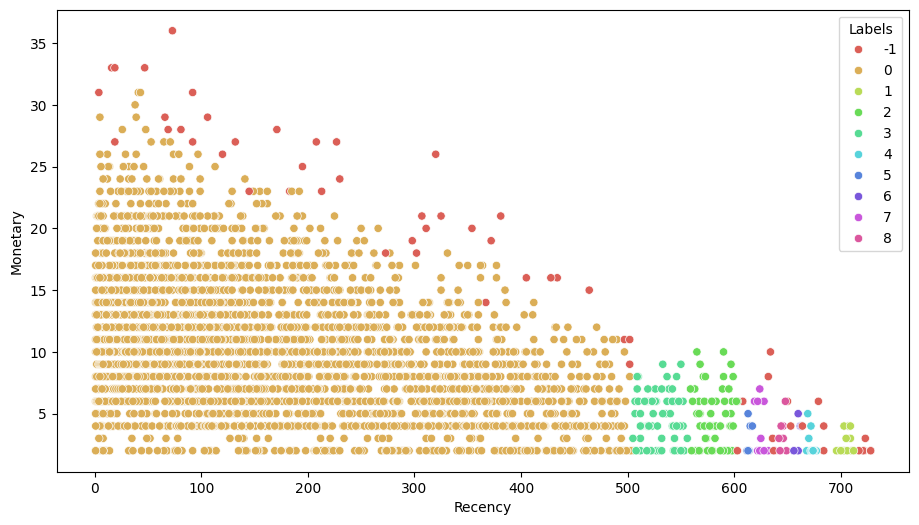

In [39]:
#Fit DBSCAN and plot Recency vs Monetary

db = DBSCAN(eps=5, min_samples=6).fit(RFM_fit)

RFM_fit['Labels'] = db.labels_
plt.figure(figsize=(11, 6))
sns.scatterplot(x="Recency", y="Monetary", data = RFM_fit, hue=RFM_fit.Labels,
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
#plt.title('DBSCAN with epsilon 5, min samples 6')
plt.show()

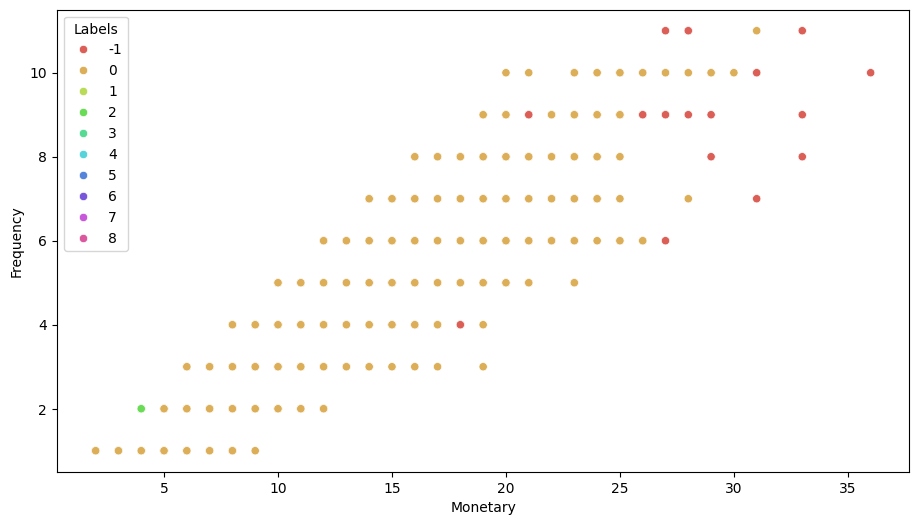

In [40]:
#Frequency vs Monetary

db = DBSCAN(eps=5, min_samples=6).fit(RFM_fit)

RFM_fit['Labels'] = db.labels_
plt.figure(figsize=(11, 6))
sns.scatterplot(x="Monetary", y="Frequency", data = RFM_fit, hue=RFM_fit.Labels,
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
#plt.title('DBSCAN with epsilon 5, min samples 6')
plt.show()

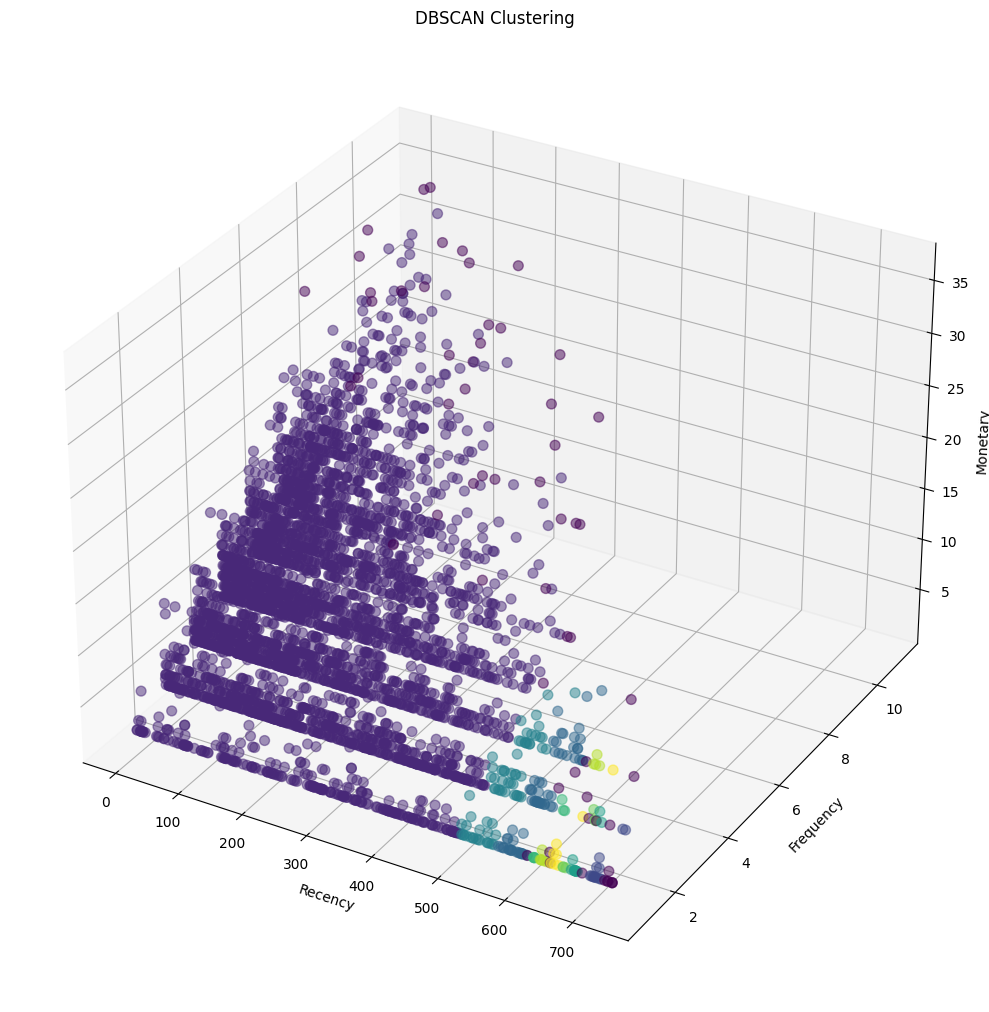

In [41]:
#Fit the 3D DBSCAN model
RFM_db = DBSCAN(eps= 5, min_samples= 6).fit(RFM_fit)
RFM_fit['Labels'] = RFM_db.labels_

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
plt.tight_layout()

# Plot the data points
ax.scatter(RFM_fit['Recency'], RFM_fit['Frequency'], RFM_fit['Monetary'], c=RFM_fit['Labels'],
           cmap='viridis', s=50, alpha=0.5)

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('DBSCAN Clustering')

#plt.title('DBSCAN with epsilon 5, min samples 6')
plt.show()

In [42]:
#Check the size of each cluster
DBSCAN_clust_sizes = RFM_fit.groupby('Labels').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes


,DBSCAN_size
Labels,
-1,60
0,3643
1,14
2,68
3,70
4,12
5,7
6,6
7,10


In [43]:
#Calculate the silhouette score
labels1=RFM_db.labels_
from sklearn import metrics
print(metrics.silhouette_score(RFM_fit, labels1))

0.4052689748029325


,Recency,Frequency,Monetary,Labels
Cluster,,,,
-1,101,101,101,101
0,3614,3614,3614,3614
1,14,14,14,14
2,66,66,66,66
3,32,32,32,32
4,38,38,38,38
5,7,7,7,7
6,6,6,6,6
7,12,12,12,12


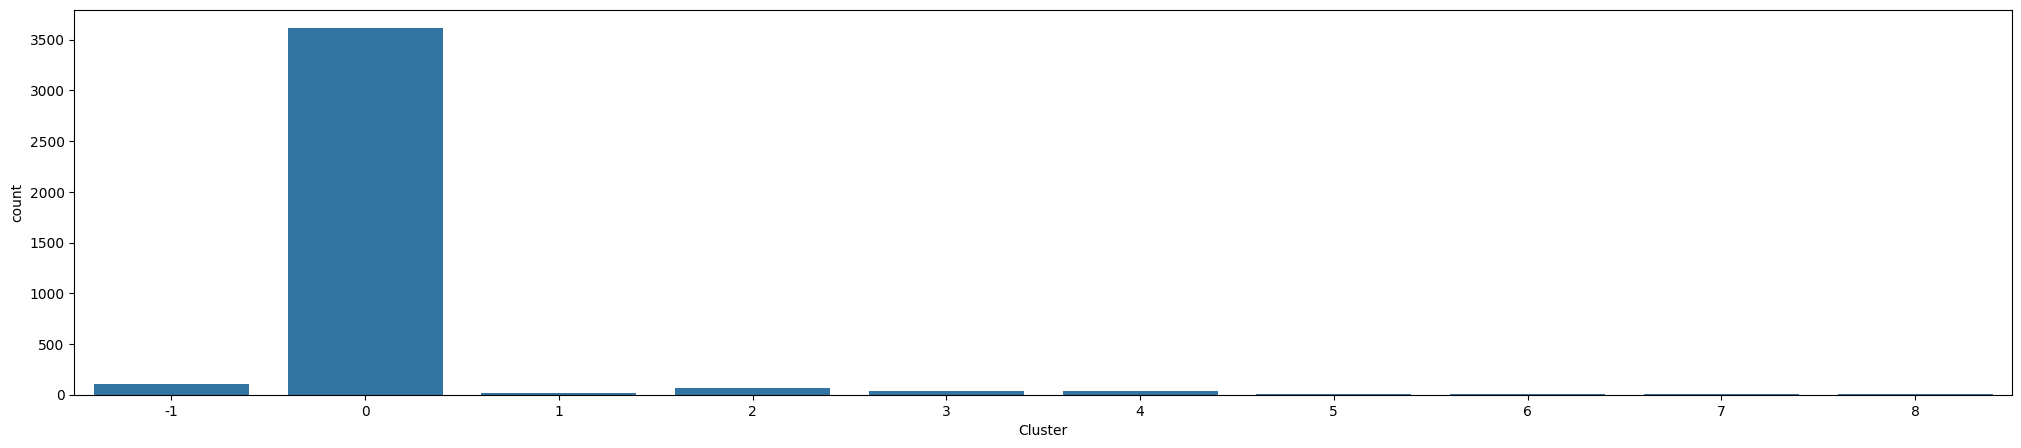

In [44]:
#Fit the DBSCAN model
RFM_db = DBSCAN(eps= 4.3, min_samples= 6).fit(RFM_fit)
RFM_fit['Cluster'] = RFM_db.labels_

RFM_db.labels_.shape
RFM_fit["Cluster"] = RFM_db.labels_
RFM_fit.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=RFM_fit)
RFM_fit.groupby(['Cluster']).count()


In [37]:
RFM_fit["Cluster"] = RFM_db.labels_
RFM_fit.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
-1       360.31      5.73    16.42   101
 0       163.93      3.89    10.05  3614
 1       704.43      1.14     2.57    14
 2       581.44      2.00     4.64    66
 3       543.19      1.94     4.84    32
 4       516.71      1.97     4.63    38
 5       613.86      1.43     3.00     7
 6       659.50      1.50     3.17     6
 7       672.75      1.17     2.50    12
 8       644.50      1.38     3.25     8